In [1]:
import sys
import os

# Adiciona o diretório raiz do projeto ao sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# **Modelagem**

Neste notebook constam todos os trabalhos de preparação de dados e modelagem com o objetivo de desenvolver o modelo final, com o mais performático.

### **Dados**

|    | label | clean_response                                                                                                                                                                                                                      | clean_report                                                                                                                                                                                           | nota_logit | nota_tree | consumidor_respondeu | dias_para_resposta | respondido | uf |
|----|-------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------|-----------|-----------------------|---------------------|-------------|----|

Aonde:
- ``label``: Indica se a reclamação foi resolvida ou não. (1 - Resolvido / 0 - Não Resolvido) - **Alvo**.
- ``clean_response``: Texto limpo da resposta da empresa à reclamação.
- ``clean_report``: Reclamação do consumidor.
- ``nota_logit``: Nota da reclamação no formato adequado para modelos vetoriais.
- ``nota_tree``: Nota da reclamação no formato adequado para modelos baseados em árvore.
- ``consumidor_respondeu``: Indica se o consumidor respondeu à resposta da empresa.
- ``dias_para_resposta``: Indica quantos dias a empresa levou para responder.
- ``respondido``: Indica se a empresa respondeu.
- ``uf``: Estado do consumidor.

### **Objetivo**

Desenvolver um modelo de Machine Learning para classificar e calcular a probabilidade de uma reclamação ser resolvida ou não a partir desses dados.

Modelos a testar:
- ANN (Redes Neurais Artificiais)
- Regressão Logística


---

### **Preparação de Ambiente**

In [2]:
# Import modules
from pandas import read_csv
import os

In [3]:
# Env vars
data_dir = 'data'
ml_dir = 'ml'
file_name = 'consumidor_gov_brasil_ml.csv'
# Project root path
root_path = os.path.dirname(os.getcwd())
# Full paths
data_path = os.path.join(root_path, data_dir, ml_dir)
file_path = os.path.join(data_path, file_name)

In [4]:
data = read_csv(file_path, sep='|', encoding='utf-8', compression='gzip').dropna(subset=['clean_report'])
data.head()

,label,clean_response,clean_report,nota_logit,nota_tree,consumidor_respondeu,dias_para_resposta,respondido,uf
0,0,flavia tudo bem acabamos responder solicitação...,solicito imediata retirada negativação indevid...,2,2.0,True,0,1,RS
1,0,karina tudo bem acabamos responder solicitação...,solicito retirada imediata dívida prescrita ai...,1,1.0,True,0,1,PR
2,1,emerson tudo bem acabamos responder solicitaçã...,solicito imediata retirada negativacão indevid...,1,1.0,True,0,1,AM
3,0,washington tudo bem acabamos responder solicit...,solicito retirada imediata cobrança dívidas ci...,3,3.0,True,0,1,AP
4,1,olá tudo bem informamos manifestação respondid...,realizei pagamento acordo quitar dívida descon...,1,1.0,True,0,1,SP


In [5]:
""" Import Modules """
import os
# Data Manipulation
from pandas import read_csv
import numpy as np
# Text Processing
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
import gensim
# Machine Learning
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


In [6]:
# Downloading resources
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('portuguese'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


---

### **Tratamento Textual:**

1. Remoção de **acentos e caracteres especiais**  
2. Remoção de **stopwords**  
3. **Tokenização**  
4. **Lematização**  
5. **Vetorização** utilizando `Word2Vec`

---

### **Word2Vec – Representação Vetorial de Palavras**

É uma técnica de **aprendizado não supervisionado** que transforma palavras em **vetores numéricos densos**, capturando **significados semânticos** e **relações contextuais**.
Diferente do TF-IDF, que é baseado em contagem, o Word2Vec aprende a **representar palavras próximas em contexto com vetores próximos no espaço vetorial**.

---

### **Como funciona?**

Baseia-se em uma **rede neural simples** com uma única camada oculta. Existem dois modelos principais:

#### 1. **CBOW (Continuous Bag of Words)**

Prediz a palavra alvo a partir do **contexto** (palavras vizinhas).

Exemplo:
Para a frase "o gato sentou no tapete", o CBOW tenta prever `"sentou"` usando `"o"`, `"gato"`, `"no"`, `"tapete"`.

#### 2. **Skip-gram**

Faz o oposto: dado uma palavra, tenta prever as **palavras do contexto**.

Exemplo:
Dado `"sentou"`, tenta prever `"o"`, `"gato"`, `"no"`, `"tapete"`.

---

### **Objetivo de treinamento**:

A rede é treinada para **maximizar a probabilidade de prever palavras corretas do contexto**.
Após o treinamento, a camada oculta da rede armazena os **vetores de palavras**.

---

### **Propriedades úteis**:

* Palavras com **significados semelhantes** têm vetores **semelhantes** (pequena distância euclidiana ou alto cosseno de similaridade).
* Capaz de capturar **relações semânticas e sintáticas**:

  Exemplo clássico:

  ```
  vetor("rei") - vetor("homem") + vetor("mulher") ≈ vetor("rainha")
  ```


In [7]:
class TextCleaner(BaseEstimator, TransformerMixin):
    """Custom transformer to clean and preprocess text data."""
    
    def __init__(self, remove_accents=False):
        self.remove_accents = remove_accents

    def clean_text(self, text: str) -> str:
        """Removes unwanted characters and normalizes the text."""
        text = text.lower()
        text = text.replace('\n', ' ')
        text = re.sub(r'[^a-záàâãéèêíïóôõöúçñü\s]', '', text, flags=re.IGNORECASE)
        if self.remove_accents:
            text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8')
            text = re.sub(r'[^a-z\s]', '', text)
        return text

    def preprocess_text(self, text: str) -> str:
        """Preprocesses the text by removing stop words and cleaning."""
        clean_text = self.clean_text(text)
        tokens = [word for word in clean_text.split() if word not in stop_words]
        return ' '.join(tokens)

    def fit(self, X, y=None) -> 'TextCleaner':
        return self

    def transform(self, X) -> list:
        return [self.preprocess_text(text) for text in X]

In [8]:
class Word2VecProcessor:
    
    def __init__(self, word2vec_model):
        """Initializes the processor with the Word2Vec model."""
        self.word2vec_model = word2vec_model

    def tokenize(self, text):
        """Tokenizes the text, keeping only alphabetic words."""
        return [word for word in text.split() if word.isalpha()]

    def get_word2vec_vector(self, tokens):
        """Generates the average Word2Vec vector for a list of tokens."""
        vec = np.zeros(self.word2vec_model.vector_size)
        count = 0
        for word in tokens:
            if word in self.word2vec_model.wv:
                vec += self.word2vec_model.wv[word]
                count += 1
        if count > 0:
            vec /= count
        return vec

class Word2VecVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, word2vec_model):
        self.word2vec_model = word2vec_model
        self.word2vec_processor = Word2VecProcessor(word2vec_model)

    def fit(self, X, y=None):
        """Fit method, required for scikit-learn compatibility."""
        return self

    def transform(self, X):
        """Transforms texts into average Word2Vec vectors."""
        return np.array([
            self.word2vec_processor.get_word2vec_vector(
                self.word2vec_processor.tokenize(text)
            ) for text in X
        ])

In [9]:
# Word2Vec Model
w2vec_processor = Word2VecProcessor(word2vec_model=None)
# Tokenize the reports and responses
tokenized_reports = data['clean_report'].apply(w2vec_processor.tokenize)
tokenized_responses = data['clean_response'].apply(w2vec_processor.tokenize)
# Combine tokenized reports and responses for Word2Vec training
corpus = tokenized_reports.tolist() + tokenized_responses.tolist()
word2vec_model = gensim.models.Word2Vec(sentences=corpus, vector_size=100, window=5, min_count=2, workers=4)

w2vec_processor.word2vec_model = word2vec_model

In [10]:
word2vec_model.save(r"C:\Users\user\Desktop\UFPB\5-Periodo\ML\Projeto\consumidor_gov\src\models\ml\word2vec.model")

In [11]:
# TF-IDF Pipeline
"""
pipeline_tfidf = Pipeline([
    ('preprocessador', TextCleaner(remove_accents=False)),
    ('vetorizador', TfidfVectorizer(max_features=5000, max_df=0.9, min_df=5))
])
"""

# Word2Vec Pipeline
pipeline_w2v = Pipeline([
    ('preprocessador', TextCleaner(remove_accents=False)),
    ('vetorizador', Word2VecVectorizer(word2vec_model=word2vec_model))
])

Aqui, além da pipeline do Word2Vec, também aplico 2 técnicas de normalização de dados:

- **StandardScaler** (Padronização): padroniza as variáveis numéricas, transformando os dados para que tenham **média 0** e **desvio padrão 1**.

- **OneHotEncoder** (Codificação One-Hot): transforma variáveis categóricas em vetores binários, criando uma nova coluna para cada categoria distinta.


In [12]:
# Colocando os pipelines em um ColumnTransformer
num_cols = ['nota_logit']
cat_cols = ['uf']

preprocessor = ColumnTransformer(
    transformers=[
        #('tfidf_report', pipeline_tfidf, 'clean_report'),
        #('tfidf_response', pipeline_tfidf, 'clean_response'),
        ('w2v_report', pipeline_w2v, 'clean_report'),
        ('w2v_response', pipeline_w2v, 'clean_response'),
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

### **Separação de Variáveis**

Aqui, separo as variáveis preditoras da alvo.

In [13]:
from src.models.transformers.preprocessor import Preprocessor
preprocessor = Preprocessor()

# Target var
Y = 'label'
# Predictive vars
X = data.columns.difference([Y, 'nota_tree'])

labels = data[Y].values 
# Processing data
processed_data = preprocessor.fit_transform(data[X])

### **Separação de Treino x Teste**

- **`test_size=0.2`**: Define a proporção dos dados que será destinada ao conjunto de teste. Neste caso, 20% dos dados são usados para teste e 80% para treinamento.
  
- **`stratify=labels`**: Garante que a divisão dos dados mantenha a distribuição das classes (labels) em ambos os conjuntos de treino e teste. Isso é importante, principalmente em problemas de classificação desbalanceada, onde algumas classes podem ser muito mais frequentes que outras.
  
- **`random_state=42`**: Define a semente (seed) do gerador de números aleatórios para que a divisão seja reprodutível. Isso significa que, ao rodar o código várias vezes, os dados serão divididos da mesma maneira cada vez.

In [14]:
# Data split
X_train, X_test, y_train, y_test = train_test_split(
    processed_data,
    labels,
    test_size=0.2,        
    stratify=labels,      
    random_state=42   
)

### **Modelagem**

Aqui, inicio a parte da modelagem preditiva, primeiramente por um modelo de Rede Neural Artificial, da lib `keras`. 

In [15]:
# Base model
model = Sequential()

#### **Hiperparâmetros**

- `InputLayer`: Camada de entrada, com a quantidade de _perceptrons_ correspondente a quantidade de features.

- `Dense`: Camada profunda. 1 camada com 64 _perceptrons_ e mais uma com 32.

- `activation`: Função de ativação de cada _perceptron_ da camada profunda. A camada de saída possui apenas 1 _perceptron_ e função sigmoide, por ser classificação binária.

In [16]:
# Entry layer
model.add(InputLayer(shape=(processed_data.shape[1],))) 
# Deep layers
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
# Exiting layer
model.add(Dense(1, activation='sigmoid'))

In [17]:
# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#### **Callback**
Um callback é uma função ou objeto que é chamado automaticamente durante o treinamento do modelo, em momentos específicos, para realizar uma ação ou modificar o comportamento do treinamento. Ele permite **monitorar** e **interromper** o treinamento com base em condições específicas, **salvar modelos**, **ajustar parâmetros**, entre outras funcionalidades.

* **`EarlyStopping`**: Um tipo de callback que monitora a **perda de validação** (`val_loss`) e interrompe o treinamento quando ela não melhora por um número de épocas consecutivas. Ele é usado para **prevenir o sobreajuste** e otimizar o tempo de treinamento.

* **`monitor`**: A métrica que o callback irá acompanhar durante o treinamento, como no caso, a **perda de validação** - `val_loss`.

* **`patience`**: O número de épocas que o modelo irá esperar sem melhorar a métrica monitorada antes de interromper o treinamento.

* **`restore_best_weights`**: Quando configurado como `True`, restaura os **pesos da melhor época** do treinamento (aquela com a menor **val\_loss** ou maior **acurácia**), garantindo que o modelo final não tenha os pesos de uma época que não representem a melhor performance.

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

# Configurando o EarlyStopping
early_stopping = EarlyStopping(
                    monitor='val_loss',  
                    patience=3,          
                    restore_best_weights=True
)

#### **Treinamento do Modelo**

* **`epochs`**: O número de **épocas** (iterações) que o modelo passará pelos dados de treinamento. Cada época consiste em uma passagem por todos os dados de treinamento, que no caso serão 10.

* **`batch_size`**: O número de exemplos que o modelo processará em cada iteração de treinamento antes de atualizar os pesos. Um tamanho de batch maior geralmente resulta em um treinamento mais eficiente, mas pode exigir mais memória.

* **`validation_data`**: Os dados de **validação** usados para avaliar o desempenho do modelo após cada época. Isso ajuda a verificar se o modelo está generalizando bem para dados que não foram usados durante o treinamento.

In [19]:
# Training
history = model.fit(
    X_train, y_train, 
    epochs=10,
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8550 - loss: 0.3277 - val_accuracy: 0.9359 - val_loss: 0.1872
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9317 - loss: 0.1914 - val_accuracy: 0.9349 - val_loss: 0.1839
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9339 - loss: 0.1836 - val_accuracy: 0.9338 - val_loss: 0.1850
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9353 - loss: 0.1784 - val_accuracy: 0.9335 - val_loss: 0.1823
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9367 - loss: 0.1737 - val_accuracy: 0.9356 - val_loss: 0.1808
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9385 - loss: 0.1652 - val_accuracy: 0.9356 - val_loss: 0.1817
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9385 - loss: 0.1646 - val_accuracy: 0.9372 - val_loss: 0.1809
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9386 - loss: 0.1582 - val_accuracy: 0.

In [20]:
# Avaliação no conjunto de teste
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

Test accuracy: 93.56%


In [21]:
# Predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")

print(classification_report(y_test, y_pred))


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      6790
           1       0.90      0.90      0.90      3209

    accuracy                           0.94      9999
   macro avg       0.93      0.93      0.93      9999
weighted avg       0.94      0.94      0.94      9999



In [22]:
import matplotlib.pyplot as plt

def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(history.history['accuracy'], label='Train Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_title('Model Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend()
    ax[1].plot(history.history['loss'], label='Train Loss')
    ax[1].plot(history.history['val_loss'], label='Validation Loss')
    ax[1].set_title('Model Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend()
    plt.show()

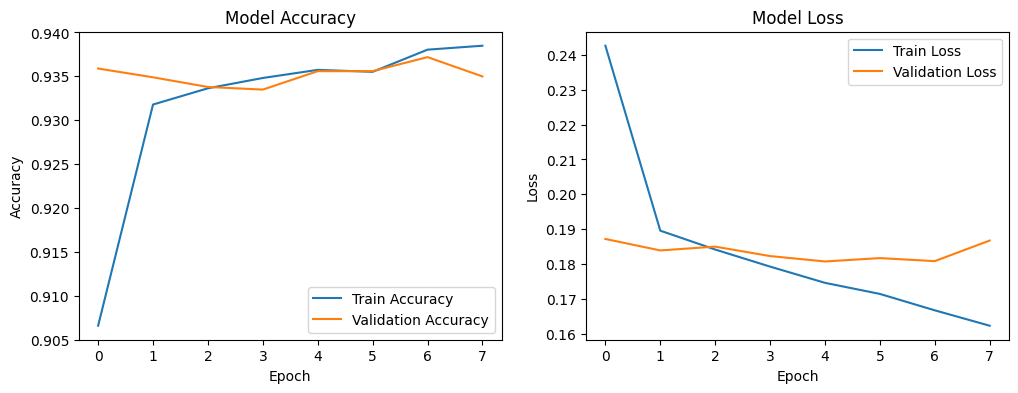

In [23]:
plot_history(history)

O modelo apresentou boa performance, com leve perda ao classificar a variável **1** _(Resolvido)_, provavelmente dado ao desbalanceamento dos dados. 

Porém, há um indicativo de leve overfitting, dado queda da acurácia da validação com a subida da acurácia de treino, e o distanciamento das perdas.

Para isso, vou remodelar utilizando o Dropout, uma técnica de penalização aleatória.

### **Remodelando**

In [24]:
new_model = Sequential()

In [25]:
new_model.add(InputLayer(shape=(processed_data.shape[1],)))

#### **Dropout**

**Dropout** é uma técnica de regularização que desativa aleatoriamente uma porcentagem de neurônios durante o treinamento de redes neurais, ajudando a **prevenir o sobreajuste** (overfitting).

* A cada iteração, **neurônios são "desligados"** de forma aleatória, forçando o modelo a aprender representações mais robustas e generalizáveis dos dados.
* A **taxa de dropout** é a fração de neurônios a ser desativada, geralmente entre **0.2 e 0.5**, no caso, **0.3**.


In [26]:
new_model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
new_model.add(Dropout(0.3))
new_model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.001)))
new_model.add(Dropout(0.3))

new_model.add(Dense(1, activation='sigmoid'))

In [27]:
new_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [29]:
new_history = new_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8046 - loss: 0.4902 - val_accuracy: 0.9271 - val_loss: 0.2508
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9242 - loss: 0.2608 - val_accuracy: 0.9359 - val_loss: 0.2156
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9298 - loss: 0.2377 - val_accuracy: 0.9372 - val_loss: 0.2055
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9326 - loss: 0.2265 - val_accuracy: 0.9374 - val_loss: 0.2010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9338 - loss: 0.2189 - val_accuracy: 0.9367 - val_loss: 0.2011
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9328 - loss: 0.2162 - val_accuracy: 0.9349 - val_loss: 0.2010
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9311 - loss: 0.2184 - val_accuracy: 0.9314 - val_loss: 0.2044
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9325 - loss: 0.2132 - val_accuracy: 0.

In [30]:
# Avaliação no conjunto de teste
new_test_loss, new_test_accuracy = new_model.evaluate(X_test, y_test, verbose=0)
print(f'Test accuracy: {new_test_accuracy * 100:.2f}%')

Test accuracy: 93.70%


In [31]:
y_pred = (new_model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      6790
           1       0.91      0.89      0.90      3209

    accuracy                           0.94      9999
   macro avg       0.93      0.93      0.93      9999
weighted avg       0.94      0.94      0.94      9999



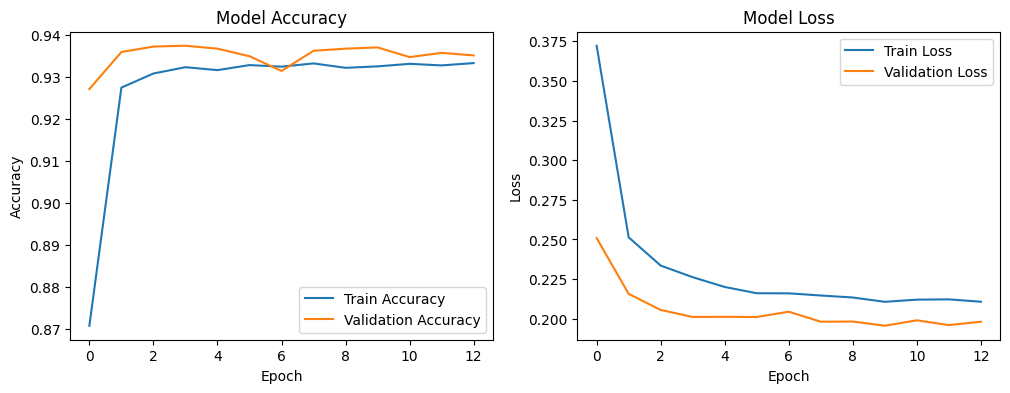

In [32]:
plot_history(new_history)

Perceba que, a performance de classificação permaneceu quase a mesma, mas o treinamento indica um modelo bem mais consistente e sem indicativo de overfitting.

#### **Matriz de Confusão**

A **matriz de confusão** é uma ferramenta usada para avaliar o desempenho de um modelo de classificação. Ela mostra o número de **verdadeiros positivos (VP)**, **falsos positivos (FP)**, **verdadeiros negativos (VN)** e **falsos negativos (FN)** produzidos pelo modelo.

* **VP (Verdadeiro Positivo)**: O modelo previu corretamente a classe positiva.
* **FP (Falso Positivo)**: O modelo previu a classe positiva, mas o valor real era negativo.
* **VN (Verdadeiro Negativo)**: O modelo previu corretamente a classe negativa.
* **FN (Falso Negativo)**: O modelo previu a classe negativa, mas o valor real era positivo.

In [33]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

labels_map = {0: 'Não Resolvido', 1: 'Resolvido'}

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues', 
        cbar=False,
        xticklabels=labels_map.values(),
        yticklabels=labels_map.values()
    )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step


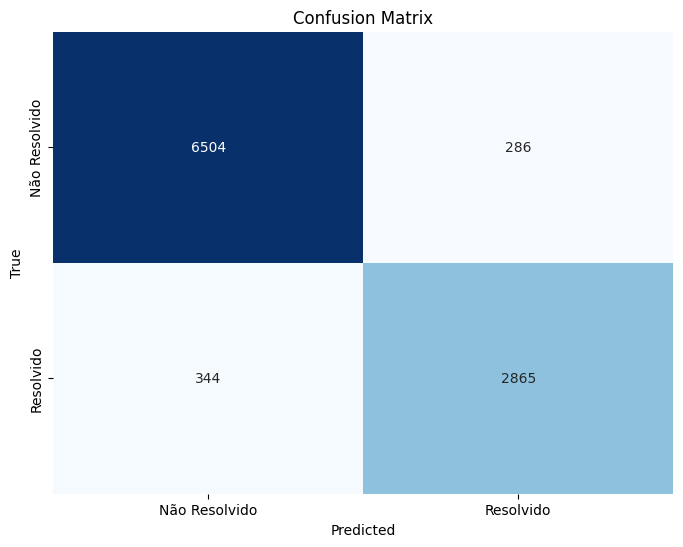

In [34]:
y_true, y_pred = y_test, (new_model.predict(X_test) > 0.5).astype("int32")
plot_confusion_matrix(y_true, y_pred)

### **Salvando Modelos**

In [35]:
# Save model - pickle

src_dir = 'src'
models_dir = 'models'
ml_dir = 'ml'
transformers_dir = 'transformers'
model_name = 'ANN_model.keras'
preprocessor_name = 'preprocessor.joblib'

model_path = os.path.join(root_path, src_dir, models_dir, ml_dir, model_name)
preprocessor_path = os.path.join(root_path, src_dir, models_dir, transformers_dir, preprocessor_name)

In [36]:
import joblib

# Saving ann
model.save(model_path)

# Saving preprocessor
joblib.dump(preprocessor, preprocessor_path)

['c:\\Users\\user\\Desktop\\UFPB\\5-Periodo\\ML\\Projeto\\consumidor_gov\\src\\models\\transformers\\preprocessor.joblib']

---

### **Regressão Logística**

Aqui usarei um modelo de regressão logística para visualizar de certa forma a importância de cada feature.

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Definindo o modelo de Regressão Logística
logreg_model = LogisticRegression(max_iter=1000, random_state=42)

In [38]:
# Treinamento do modelo
logreg_model.fit(X_train, y_train)
# Avaliação no conjunto de teste
y_pred_logreg = logreg_model.predict(X_test)

In [39]:
print(classification_report(y_test, y_pred_logreg))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      6790
           1       0.91      0.87      0.89      3209

    accuracy                           0.93      9999
   macro avg       0.93      0.92      0.92      9999
weighted avg       0.93      0.93      0.93      9999



#### **Grid Search**

O **Grid Search** é uma técnica de otimização de **hiperparâmetros**. Ele testa **todas as combinações possíveis** de um conjunto pré-definido de valores para encontrar a **melhor configuração** para o modelo.

In [40]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs'],
    'penalty': ['l2'],
}

In [41]:
# Configurando o GridSearchCV
from sklearn.model_selection import GridSearchCV

grid_model = LogisticRegression(max_iter=1000, random_state=42)

grid_search = GridSearchCV(
    estimator=grid_model, 
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1, 
    scoring='accuracy', 
    verbose=1
)

In [42]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2'],
                         'solver': ['liblinear', 'lbfgs']},
             scoring='accuracy', verbose=1)

In [43]:
print("Best parameters:", grid_search.best_params_)

Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


Esses foram os parâmetros que resultaram em uma melhor performance do modelo.

In [44]:
best_lr_model = grid_search.best_estimator_

In [45]:
test_accuracy = best_lr_model.score(X_test, y_test)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

Test accuracy: 93.25%


In [46]:
y_pred = best_lr_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      6790
           1       0.91      0.87      0.89      3209

    accuracy                           0.93      9999
   macro avg       0.93      0.92      0.92      9999
weighted avg       0.93      0.93      0.93      9999



#### **Gráfico AUC - ROC (Regressão Logística)**

O gráfico **ROC (Receiver Operating Characteristic)** é uma ferramenta para avaliar o desempenho de classificadores binários. Ele mostra a relação entre:

* **True Positive Rate (TPR)**: sensibilidade.
* **False Positive Rate (FPR)**: taxa de falsos positivos.

#### **AUC (Area Under the Curve)**

A área sob a curva (**AUC**) resume o desempenho do modelo.

* Valor **próximo de 1.0** indica excelente separação entre classes.
* Valor **próximo de 0.5** indica que o modelo **não está melhor do que o chute aleatório**.

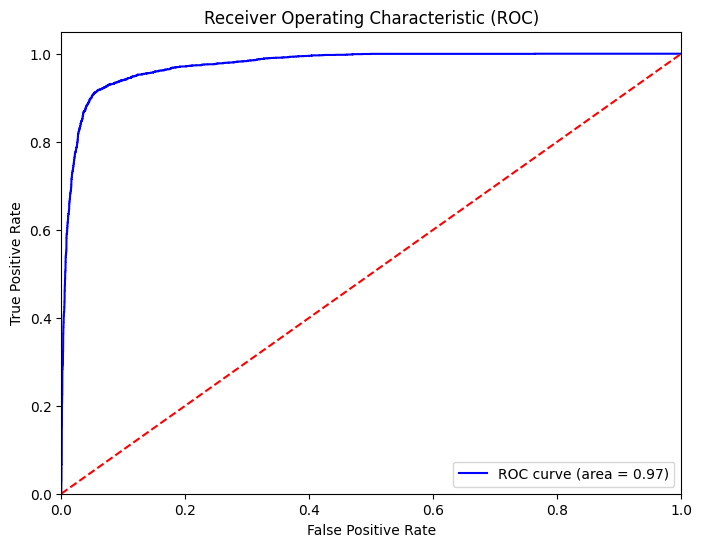

In [47]:
# Plot AUC - ROC Curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_pred_proba = best_lr_model.predict_proba(X_test)[:, 1]
# Calc ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
# ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

O modelo apresentou excelente separação entre as classes.

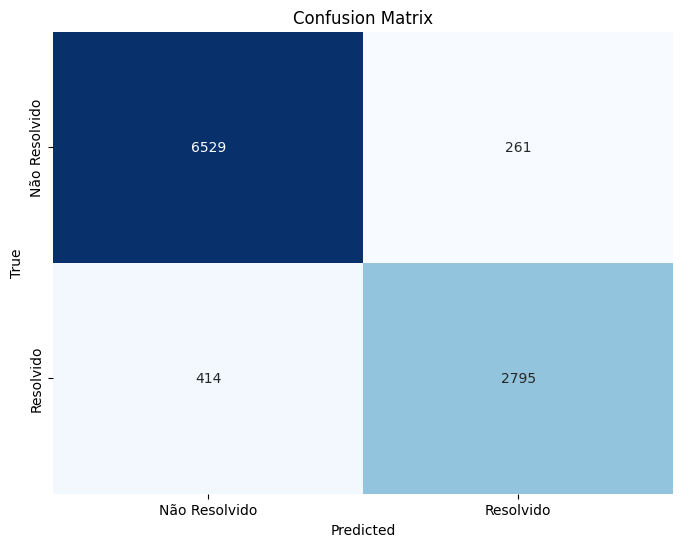

In [48]:
# plot confusion matrix
y_lr_pred, y_lr_pred_proba = y_test, best_lr_model.predict(X_test)
plot_confusion_matrix(y_lr_pred, y_lr_pred_proba)

### **Saving Models**

In [49]:
# Saving regression model
import pickle

model_name = 'logit_model.pkl'
model_path = os.path.join(root_path, src_dir, models_dir, ml_dir, model_name)

with open(model_path, 'wb') as file:
    pickle.dump(best_lr_model, file)

---